In [26]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, IFrame, Video
import ipywidgets as widgets
from ipywidgets import interact, fixed, Dropdown, Checkbox, FloatSlider, IntSlider, Output, VBox, HBox

from numpy import cos, sin, tan, arctan, exp, log, pi, sqrt, array, linspace, arange
from numpy.linalg import norm
from mpl_toolkits import mplot3d

from scipy.integrate import quad
%matplotlib widget

# Uncomment the one that corresponds to your Jupyter theme
plt.style.use('default')
# plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')
# plt.style.use('Solarize_Light2')

plt.rcParams.update({
    "figure.figsize": (7,7),
    "text.usetex": True,
    "font.family": "serif",
})


$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\bv}[1]{\begin{bmatrix} #1 \end{bmatrix}}$
$\renewcommand{\vec}{\mathbf}$


# One-minute Review

A space curve can represent the **position** of a body at time $t$. $$\vec r(t) = x(t)\vec i + y(t) \vec j + z(t) \vec k.$$ 

Its derivative $$\vec r'(t) = x'(t)\vec i + y'(t) \vec j + z'(t) \vec k$$ is the **velocity vector**. Its magnitude is the **speed**.

The second derivative $\vec r''(t)$ is the **acceleration**. 

<p style="padding-bottom:40%;"> </p>

In [2]:
def a(TITLE):
    
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE)
    plt.ion()
    
    ax = fig.add_subplot(projection='3d')
 
    # make axes lines
    ax.plot([-1,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[-1,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[-1,1],'gray')

    s = np.linspace(-1,1,300)

    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
        
    ax.set_autoscale_on(True)

    r1 = lambda t: np.array([t,t**2,t**3])
    r2 = lambda t: np.array([cos(2*pi*t),sin(2*pi*t),t])
    r3 = lambda t: np.array([cos(8*pi*t),sin(3*pi*t),sin(7*pi*t)])
        
    X,Y,Z = np.column_stack([r1(x) for x in s])
    pl = ax.plot(X,Y,Z,alpha=1,lw=3)[0]
    
    rw = Dropdown(options={"twist":r1, "helix": r2, "wacky": r3})
    osc = Checkbox(value=False, description="Osculating Plane")
    tw = FloatSlider(min=-1, max=1, step=.01, description="$t$")
    
    def update_rw(change):
        r = change['new']
        X,Y,Z = np.column_stack([r(x) for x in s])

        pl.set_data_3d(X, Y, Z)
        update_t({'new': tw.value})
    
    def update_t(change):
        r = rw.value
        t = change['new']
        while ax.collections:
            ax.collections.pop()

        ax.quiver(0,0,0,r(t)[0],r(t)[1],r(t)[2])
        v = (r(t+.004) - r(t-.004))*250
        v = v/norm(v) # scale for visibility only
        ax.quiver(r(t)[0],r(t)[1],r(t)[2],v[0],v[1],v[2],color="green")
        a = (r(t+.004) - r(t)*2 + r(t-.004))*250**2
        a = a/norm(a) # scale for visibility only
        ax.quiver(r(t)[0],r(t)[1],r(t)[2],a[0],a[1],a[2],color="red")
        if osc.value:
    #         verts=[r(t) + v + a,r(t) + v - a,r(t) - v - a]
    #         ax.add_collection3d(Poly3DCollection(verts,alpha=.3))
    #         verts=[r(t) + v + a,r(t) - v - a,r(t) - v + a]
    #         ax.add_collection3d(Poly3DCollection(verts,alpha=.3))
            xs,ys,zs = np.column_stack([r(t) + v + a,r(t) + v - a,r(t) - v + a,r(t) - v - a])
            ax.plot_surface(xs.reshape(2,2),ys.reshape(2,2),zs.reshape(2,2),color='lightblue', alpha=.3,zorder=.6)
            for c in 'xyz':
                getattr(ax,f"set_{c}lim")([-1,1]);    
    
    def update_osc(change):
        update_t({'new': tw.value})
        
    tw.observe(update_t, names='value')
    rw.observe(update_rw, names='value')
    osc.observe(update_osc, names='value')
    
    return VBox([HBox([tw, rw, osc]), fig.canvas])
            
a("Motion")

[Another example](https://3demos.surge.sh/?currentChapter=Intro&shadeUp=true&flipInfo=true&obj0_kind=parsurf&obj0_params_rNum=10&obj0_params_cNum=10&obj0_params_nX=60&obj0_params_a=0&obj0_params_b=2*pi&obj0_params_c=0&obj0_params_d=2*pi&obj0_params_x=cos%28u%29*%281+%2B+sin%28v%29%2F3%29&obj0_params_y=sin%28u%29*%281+%2B+sin%28v%29%2F3%29&obj0_params_z=cos%28v%29%2F3&obj1_kind=curve&obj1_params_a=0&obj1_params_b=10*pi&obj1_params_x=cos%28t%29*%281+%2B+cos%2814%2F5+t%29%2F3%29&obj1_params_y=sin%28t%29*%281+%2B+cos%2814%2F5+t%29%2F3%29&obj1_params_z=sin%2814%2F5+t%29%2F3&obj1_params_tau=0)

<p style="padding-bottom:40%;"> </p>

# Lecture 06

  - Objectives

    - Compute arc length of curves.
    - Parameterize by arc length. 
    - Explain the quantity $\kappa$, the curvature.
  
  - Resources
    - Content
      - Stewart: §13.3-4
      - New Strang: [§3.3](https://cnx.org/contents/oxzXkyFi@5.30:9fEOYsBF@9/3-3-Arc-Length-and-Curvature) [§3.4]()
    - Visualization
      - [CalcPlot3D](https://www.monroecc.edu/faculty/paulseeburger/calcnsf/CalcPlot3D/)
    - Practice
      - Mooculus: [Motion and Paths in Space](https://ximera.osu.edu/mooculus/calculus3/motionAndPathsInSpace/titlePage)
    - Extras
      - CalcBLUE: [Vector Calculus and Motion](https://www.youtube.com/watch?v=rq4kxVFnOUA&index=48&list=PL8erL0pXF3JYm7VaTdKDaWc8Q3FuP8Sa7)

<p style="padding-bottom:40%;"> </p>

# Arc Length

Most have an intuition for what is meant by the length of a curving path. But carefully formulating it gives rise rather quickly to a fundamental formula.

In [3]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE)
    plt.ion()
    ax = fig.add_subplot(projection='3d') 
    
    # make axes lines
    ax.plot([-1,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[-1,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[-1,1],'gray')   

    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    
    ax.set_autoscale_on(True)
    
    r = lambda t: np.array([cos(2*pi*t),sin(2*pi*t),sin(6*pi*t)])

    s = np.linspace(0,1,300)

    X,Y,Z = np.column_stack([r(x) for x in s])
    ax.plot(X,Y,Z,alpha=1,lw=3)
    
    s = np.linspace(0,1,2)
    X,Y,Z = np.column_stack([r(x) for x in s])
    poly = ax.plot(X,Y,Z,alpha=1,lw=3)[0]
    
    def update(change):
        n = change.get('new', 1)
        s = np.linspace(0,1,n + 1)
        X,Y,Z = np.column_stack([r(x) for x in s])
        poly.set_data_3d(X,Y,Z)
    
    slider = widgets.IntSlider(min=3, max = 50)
    slider.observe(update, names='value')
    
    return widgets.VBox([slider, fig.canvas])

a("Approximating Arc Length")

<p style="padding-bottom:40%;"> </p>

## Arc Length

So a reasonable approximation is 

$$\sum_{i=1}^n |\vec r(a + i \Delta t) - \vec r(a+(i-1)\Delta t)|$$ 

$$ = \sum_{i=1}^n \left|\frac{\vec r(a + i \Delta t) - \vec r(a+(i-1)\Delta t)}{\Delta t}\right| \Delta t $$ since $\Delta t >0$.

$$ \longrightarrow \int_a^b |\vec r'(t)|\,dt$$


<p style="padding-bottom:40%;"> </p>

### Example

Find the arc length of one coil of the helix $$\cos t\,\vec i + \sin t\,\vec j + t\,\vec k.$$

In [4]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE)
    plt.ion()
    ax = fig.add_subplot(projection='3d') 
    
    # make axes lines
    ax.plot([-1,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[-1,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[-1,1],'gray')   

    for c in 'xyz':
        # getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    
    ax.set_ylim3d((-1,2*pi-1))
    ax.set_xlim3d((-2*pi+1,1))
    
    
    pw = widgets.FloatSlider(min=0, max=.6, description="Paper:", readout=False)
    slider = widgets.FloatSlider(min=0, max=2*pi, description="Unroll:", readout=False)

    unroll = slider.value
    paper = pw.value
    t = arange(0,unroll+pi/100,pi/100)
    pl = ax.plot(np.ones_like(t),t,t,color='b')[0]
    x,y=np.meshgrid(t,linspace(0,2*pi,3))
    sheet=ax.plot_surface(np.ones_like(x),x,y,zorder=-1,alpha=paper,color='orange')
    t = arange(0,2*pi-unroll+pi/100,pi/100)
    pl2 = ax.plot(cos(t),unroll + sin(t),t+unroll,color='b')[0]
    x,y=np.meshgrid(t,linspace(0,2*pi,3))
    if unroll < 2*pi:
        ax.plot_surface(cos(x),unroll*np.ones_like(x) + sin(x),y,zorder=-1,alpha=paper,color='orange')
    
    def update(change):
        
        while ax.collections:
            ax.collections.pop()
        
        unroll = slider.value
        paper = pw.value
        t = arange(0,unroll+pi/100,pi/100)
        pl.set_data_3d(np.ones_like(t),t,t)
        x,y=np.meshgrid(t,linspace(0,2*pi,3))
        ax.plot_surface(np.ones_like(x),x,y,zorder=-1,alpha=paper,color='orange')
        t = arange(0,2*pi-unroll+pi/100,pi/100)
        pl2.set_data_3d(cos(t),unroll + sin(t),t+unroll)
        x,y=np.meshgrid(t,linspace(0,2*pi,3))
        if unroll < 2*pi:
            ax.plot_surface(cos(x),unroll*np.ones_like(x) + sin(x),y,zorder=-1,alpha=paper,color='orange')
    
    slider.observe(update, names='value')

    def update_opaq(change):
        o = change.get('new', 1)
        sheet.set_alpha(o)
    
    pw.observe(update, names='value')
    
    
    return widgets.VBox([HBox([pw, slider]), fig.canvas])

a("Length of a Helix")

<p style="padding-bottom:40%;"> </p>

## Reparametrization

The same path in space can be traced in any number of ways—fast, slow, backwards. The process of changing this is called **reparametrization**. In effect, we replace the argument to a curve $\vec r(t)$ with a different scalar-valued function to make $\vec r(f(t))$.

#### Quick example

$\langle \cos t, \sin t\rangle$ traces out the unit circle over the interval $[0,2\pi]$.

$\langle \cos (6\pi t), \sin (6\pi t)\rangle$ traces out the unit circle much "faster", over the interval $[0,\frac13]$.

Take the derivatives of each of the above to see this.

[Demo](https://3demos.surge.sh/?currentChapter=Intro&shadeUp=false&flipInfo=true&grid=true&obj0_kind=curve&obj0_params_a=0&obj0_params_b=1&obj0_params_x=cos%286+*+pi+*+t%29&obj0_params_y=sin%286+*+pi+*+t%29&obj0_params_z=0&obj0_params_tau=0.670341096805371&obj0_params_color=%231c00a8)

<p style="padding-bottom:40%;"> </p>

#### Exercise

Find a parameterization $\mathbf r(t)$ of a circle of radius $a$ such that the speed is 1 for all $t$. 

<p style="padding-bottom:40%;"> </p>

### Parametrization by arc length

Let $\vec r(t)$ for $t\in[a,b]$ be a smooth (i.e., $|\vec r'(t)| \neq 0$) curve. Let $$s= \ell(t) = \int_a^t |\vec r'(\tau)|\,d\tau$$ be the arc length function.

In [30]:
# Video("../img/arc_length.mp4")
Video("../img/arc_length.mp4", html_attributes="loop autoplay")

#### 

In [28]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE,figsize=(10, 5))
    ax = fig.add_subplot(121, projection="3d")
    ax2 = fig.add_subplot(122)
    plt.ion()
    
    # Make data.
    ts = linspace(0, 2*pi, 300)
    
    slider=FloatSlider(min=0, max=2*pi, step=pi/50, value=0)
    
    ax.plot(cos(ts), sin(ts), (1 - cos(ts))*sin(3*ts))
    p1 = ax.plot([], [], [], lw=4, color='r')[0]
    p2 = ax2.plot([], [], 'r')[0]

    ax2.set_xlim(0, 2*pi)
    ax2.set_ylim(0, 16)
    
    for c in "xyz":
        getattr(ax,f"set_{c}label")(f"${c}$", fontsize=20)
        getattr(ax,f"set_{c}lim")(-1.5,1.5)


    ax.plot([-1.5,1.5],[0,0],[0,0],'k',lw=2)
    ax.plot([0,0],[-1.5,1.5],[0,0],'k',lw=2)
    ax.plot([0,0],[0,0],[-1.5,1.5],'k',lw=2)    

        
    def update(change):
        b = slider.value
        if b>0:
            ss = linspace(0,b, int((300*b)/(2*pi)+1))
            p1.set_data_3d(cos(ss), sin(ss), (1 - cos(ss))*sin(3*ss))
            p2.set_data(ss, [quad(
                lambda r: sqrt(1 + ((1 - cos(r))*3*cos(3 * r) + sin(r)*sin(3*r))**2)
                , 0, n)[0] for n in ss])
   
    slider.observe(update, names='value')
    
    return VBox([slider, fig.canvas])

a("Arc length as function")

#### Remarks

  - $L = \ell(b)$ is the length of the curve.
  
  - $\frac{ds}{dt} = \ell'(t) = |\vec r'(t)|$.
  
  - $\ell(t)$ is monotonically increasing, thus invertible. $$t = \ell^{-1}(s)$$
  
  - We write $\vec r(\ell^{-1}(s))$ for $s\in [0,L]$ to be this curve **parametrized by arc length**.
  
  - $\frac{d}{ds} \vec r(\ell^{-1}(s)) = \vec r'(\ell^{-1}(s)) \frac{1}{\ell'(\ell^{-1}(s))} = \frac{\vec r'(t)}{|\vec r'(t)|} = \vec T$, the unit tangent vector

#### 
<p style="padding-bottom:40%;"> </p>

### Example

Parametrize the [curve](https://3demos.surge.sh/?currentChapter=Intro&shadeUp=false&flipInfo=true&grid=false&obj0_kind=curve&obj0_params_a=0&obj0_params_b=sqrt%284*pi%29&obj0_params_x=cos%28t%5E2%29&obj0_params_y=sin%28t%5E2%29&obj0_params_z=t%5E2+%2F+%28pi%29&obj0_params_tau=0.7400756589735245&obj0_params_color=%23005aa7https://3demos.surge.sh/?currentChapter=Intro&shadeUp=false&flipInfo=true&grid=false&obj0_kind=curve&obj0_params_a=0&obj0_params_b=sqrt%284*pi%29&obj0_params_x=cos%28t%5E2%29&obj0_params_y=sin%28t%5E2%29&obj0_params_z=t%5E2+%2F+%28pi%29&obj0_params_tau=0.7400756589735245&obj0_params_color=%23005aa7) $$\langle e^{-t}, 1-2e^{-t}, 2e^{-t} \rangle$$ for $t \geq 0$ by arc length. 

<p style="padding-bottom:40%;"> </p>

## Curvature

Which of these curves is "curviest" at the origin?

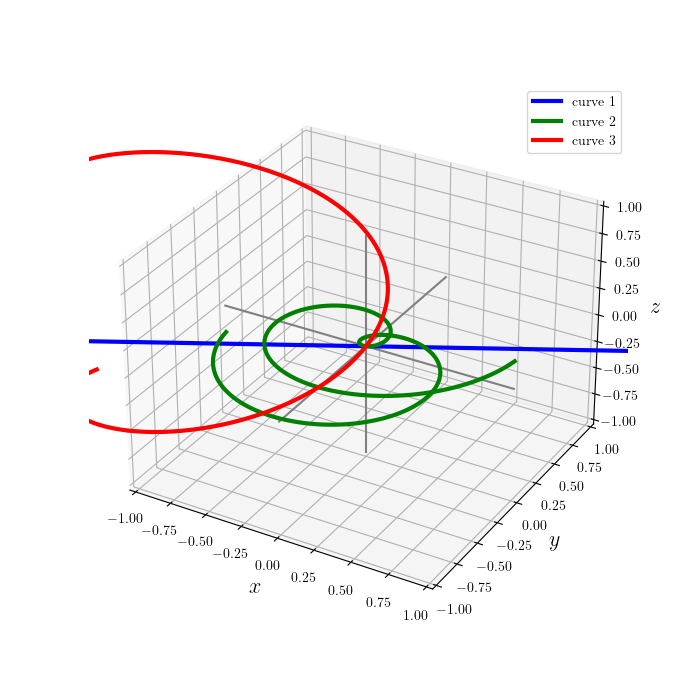

In [31]:
def a(TITLE):
    r1 = lambda t: np.array([t,2*t,-t])
    r2 = lambda t: np.array([t*cos(2*pi*t),t*sin(2*pi*t),t/4])
    r3 = lambda t: np.array([cos(pi*t)-1,sin(pi*t),t])

    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE)
    plt.ion()
    ax = fig.add_subplot(projection='3d') 
    
    # make axes lines
    ax.plot([-1,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[-1,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[-1,1],'gray')   

    s = np.linspace(-1,1,300)
    # ax.set_autoscale_on(True)
    
    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)

    for i,r in enumerate((r1,r2,r3)):
        X,Y,Z = np.column_stack([r(x) for x in s])
        ax.plot(X,Y,Z,alpha=1,color='bgr'[i],lw=3,label=f"curve {i+1}");
#     v,w =[r(t),(r(t+.01)-r(t-.01))/.07]
    ax.legend()
    return fig.canvas
        
a("Three Curves")

[3Demos version](https://3demos.surge.sh/?currentChapter=Intro&shadeUp=true&flipInfo=true&grid=true&obj0_kind=curve&obj0_params_a=-2&obj0_params_b=2&obj0_params_x=cos%28pi*t%29+-+1&obj0_params_y=sin%28pi*t%29&obj0_params_z=t&obj0_params_tau=0&obj0_params_color=%23ff0000&obj1_kind=curve&obj1_params_a=-1&obj1_params_b=1&obj1_params_x=t+cos%282+pi+t%29&obj1_params_y=t+sin%282+pi+t%29&obj1_params_z=t+%2F+4&obj1_params_tau=0&obj1_params_color=%2300ff00&obj2_kind=curve&obj2_params_a=-1&obj2_params_b=1&obj2_params_x=t&obj2_params_y=2+t&obj2_params_z=-t&obj2_params_tau=0&obj2_params_color=%230000ff)

<p style="padding-bottom:40%;"> </p>

#### Definition of curvature

Recall that $\vec T$ is the **unit tangent vector** to a curve $\vec r(t)$. The **curvature** $\kappa$ of $\vec r$ at a given point is given by 

<div style="font-size: 2em">

$$\kappa = \left|\frac{d\vec T}{ds} \right|.$$
    
</div>

<p style="padding-bottom:40%;"> </p>

##### Formula

Perhaps a more useful formula comes from $\vec T'(t) = \frac{d\vec T}{ds} \frac{ds}{dt} $, or 

$$\kappa = \frac{|\vec T'(t)|}{|\vec r'(t)|}.$$

<p style="padding-bottom:40%;"> </p>

### Example

Find the curvature of a circle of radius $a$. 

In [6]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))

    plt.ioff()
    fig,ax = plt.subplots(num=TITLE)
    plt.ion()
    
    t = linspace(-pi,pi,500)

    p = ax.plot([],[])[0]

    aw = widgets.FloatSlider(min=1, max = 10, step=.3, description="radius", readout_format='.1f')
    sw = widgets.FloatSlider(min=-1, max = 1, step=.01, readout=False)

    ax.set_xticks(arange(-1,11.5,.5))
    ax.set_yticks(arange(-2,2,.5))
    
    ax.grid(True)
    
    def update(change):
        a, s = aw.value, sw.value

        p.set_data(a*cos(t/a),a*sin(t/a))

        while ax.collections:
            ax.collections.pop()
        
        ax.quiver(a*cos(s/a),a*sin(s/a),-sin(s/a),cos(s/a),angles='xy', scale_units='xy', scale=1,color='red')
        ax.set_xlim((a-2,a+1))
        ax.set_ylim((-1.5,1.5))
        ax.set_aspect('equal')
    
    update({'new': 1})
    
    aw.observe(update, names='value')

    sw.observe(update, names='value')
    
    return widgets.VBox([HBox([aw, sw]), fig.canvas])

a("κ of a circle")